In [1]:
import os
import numpy as np
from scipy import sparse
from tqdm.auto import tqdm, trange
from collections import namedtuple
import json
import pickle
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset

from torchfm.model.efm import EmbeddingFactorizationMachineModel

from tevatron.modeling import DenseModel

In [2]:
%ls models

bce/                     fm_k768_ip_if0.1/
ce_init_identity/        fm_k768_ip_if0.1_nolrscheduler/
fm_k768_ip_cocondenser/  fm_k768_ip_if0_nolrscheduler/
fm_k768_ip_if0/          fm_k768_ip_if1_nolrscheduler/


In [22]:
def weight_heatmap(x_weight, z_weight):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    ax = axs[0]
    im = ax.imshow(x_weight, cmap='hot', interpolation='nearest')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title('x weights')

    ax = axs[1]
    im = ax.imshow(z_weight, cmap='hot', interpolation='nearest')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title('z weights')
    
    plt.show()

def visualize_weights(model_dir, mode='asym'):
    fm = EmbeddingFactorizationMachineModel.load(model_dir)
    fm.eval()
    
    if mode == 'asym':
        x_weight = fm.x_dim_reduc.weight.detach().numpy()
        z_weight = fm.z_dim_reduc.weight.detach().numpy()

        print(np.linalg.norm(x_weight - np.eye(768)))
        print(np.linalg.norm(z_weight - np.eye(768)))
    
    if mode == 'sym':
        Q = fm.x_dim_reduc.Q.detach().numpy()
        diag = np.diag(fm.x_dim_reduc.diag.detach().numpy())
        x_weight = Q @ diag @ Q.T
        z_weight = np.eye(len(Q))
        
        print(np.linalg.norm(x_weight - np.eye(768)))

    weight_heatmap(x_weight, z_weight)
    
def visualize_tevatron(model_dir):
    model = DenseModel.load(model_dir)
    
    print(model.pooler.linear_q.weight.dtype, model.pooler.linear_p.weight.dtype)
    
    x_weight = model.pooler.linear_q.weight.detach().numpy()
    z_weight = model.pooler.linear_p.weight.detach().numpy()
    
    weight_heatmap(x_weight, z_weight)

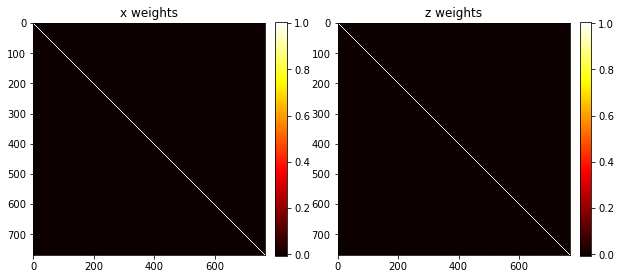

In [28]:
model_dir = 'models/ce_init_identity/fm_k768_ip_cocondenser/'
visualize_weights(model_dir)

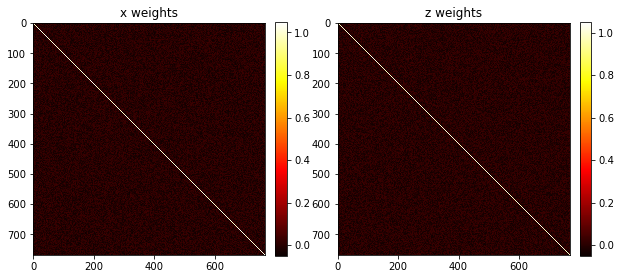

In [24]:
model_dir = 'models/fm_k768_ip_cocondenser/'
visualize_weights(model_dir)

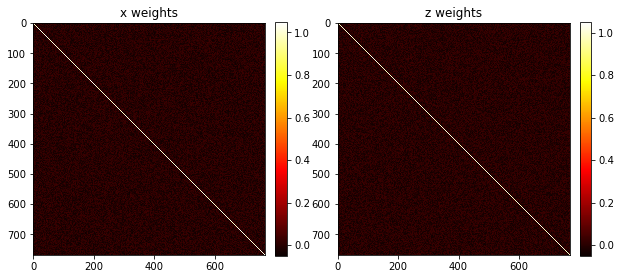

In [7]:
model_dir = 'models/ce_init_random/fm_k768_ip_if1/'
visualize_weights(model_dir)

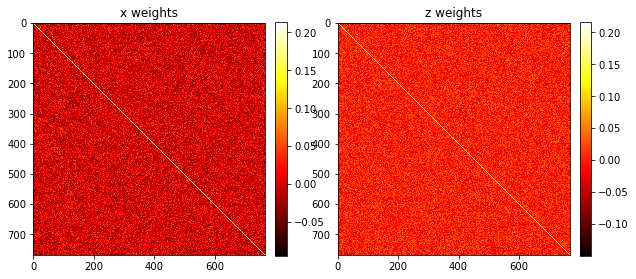

In [26]:
model_dir = 'models/ce_init_random/fm_k768_ip_if0.1/'
visualize_weights(model_dir)

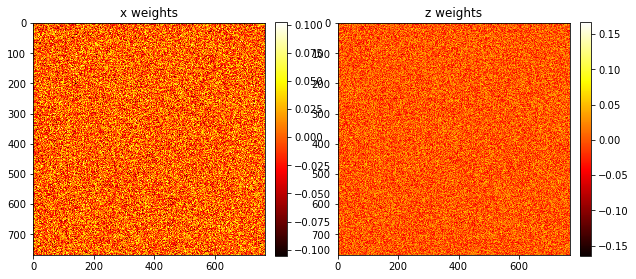

In [27]:
model_dir = 'models/ce_init_random/fm_k768_ip_if0/'
visualize_weights(model_dir)

In [11]:
layer = torch.nn.Linear(768, 768, bias=False)

In [13]:
print(np.linalg.norm(layer.weight.detach().numpy()))

15.997609


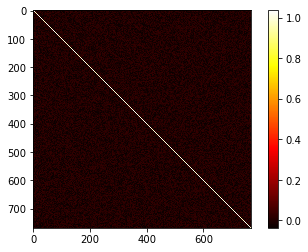

In [19]:
plt.imshow(layer.weight.detach().numpy() + np.eye(768) * 1, 
           cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

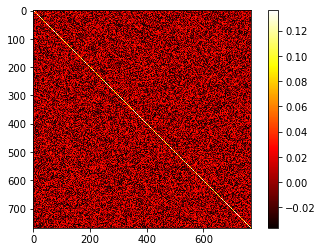

In [20]:
plt.imshow(layer.weight.detach().numpy() + np.eye(768) * 0.1, 
           cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

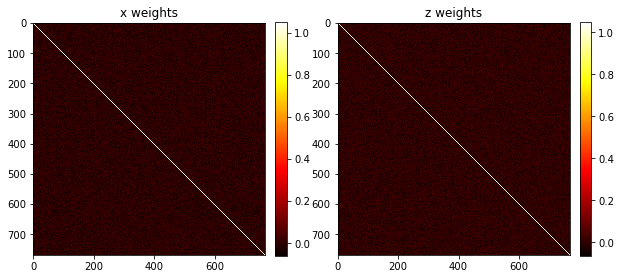

In [4]:
model_dir = 'models/ce_init_random/fm_k768_ip_if1_nolrscheduler/'
visualize_weights(model_dir)
# best mrr@10_tst = 0.3678 (loss_trn = 0.1447)
# starts to overfit

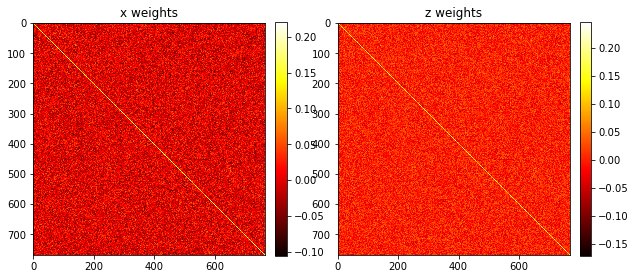

In [5]:
model_dir = 'models/ce_init_random/fm_k768_ip_if0.1_nolrscheduler/'
visualize_weights(model_dir)
# best mrr@10_tst = 0.36 (loss_trn = 0.1463)
# starts to slightly overfit

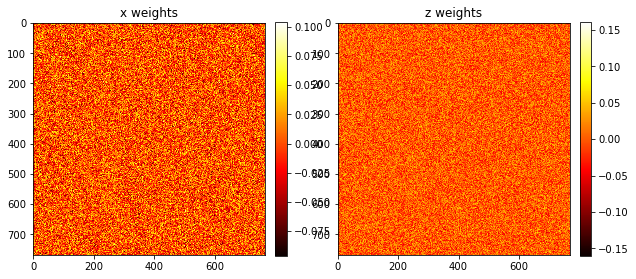

In [6]:
model_dir = 'models/ce_init_random/fm_k768_ip_if0_nolrscheduler/'
visualize_weights(model_dir)
# best mrr@10_tst = 0.3617 (loss_trn = 0.1439)
# not much overfitting

16.21558935967567
16.188883374623707


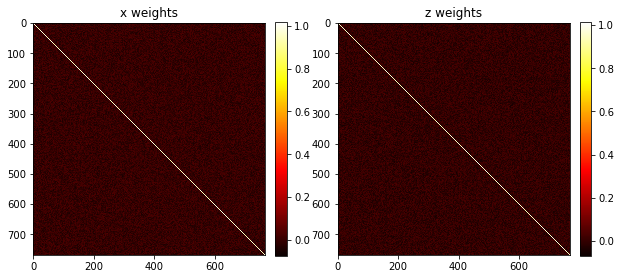

In [10]:
model_dir = 'models/stage1/fm_k768_400k_ip_if1/'
visualize_weights(model_dir)

33.33965641036062
33.15415500434358


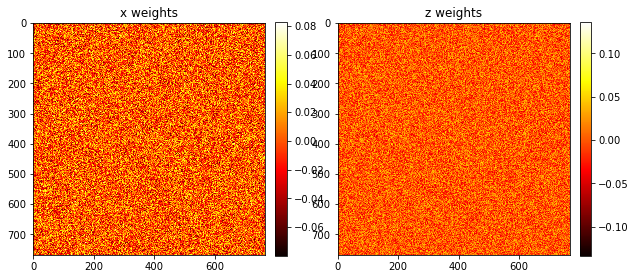

In [14]:
model_dir = 'models/stage1/fm_k768_400k_ip_if0/'
visualize_weights(model_dir)

30.43865810056916
30.322306069880504


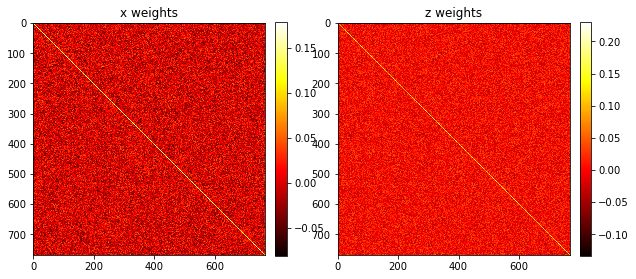

In [15]:
model_dir = 'models/stage1/fm_k768_400k_ip_if0.1/'
visualize_weights(model_dir)

torch.float32 torch.float32
32.0393358148231
32.0393358148231


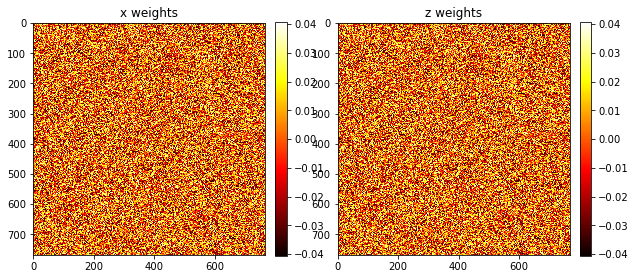

In [13]:
visualize_tevatron('../tevatron/examples/coCondenser-marco/retriever_model_s1_sympool/')

torch.float32 torch.float32
32.039880920073756
32.00500319898042


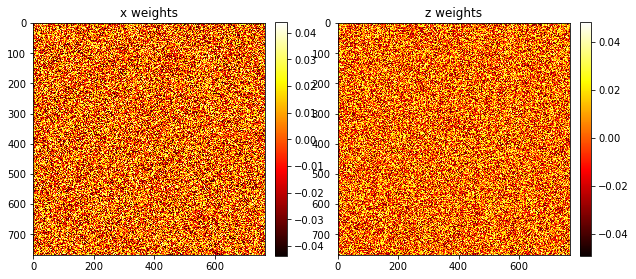

In [14]:
visualize_tevatron('../tevatron/examples/coCondenser-marco/retriever_model_s1_asympool/')

In [21]:
model = DenseModel.load('../tevatron/examples/coCondenser-marco/retriever_model_s1_sympool/')
model

DenseModel(
  (lm_q): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [18]:
model = DenseModel.load('../tevatron/examples/coCondenser-marco/retriever_model_s1_v0/')
model.lm_q

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

30712.919075540216


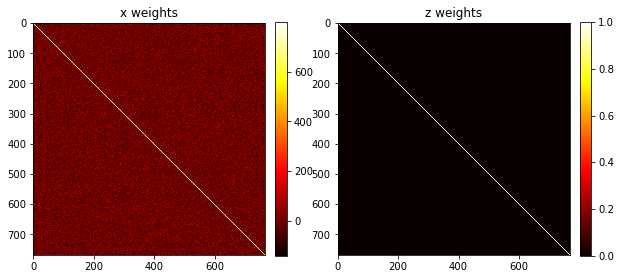

In [12]:
model_dir = 'models/fm_ip_symmetric_if1/'
visualize_weights(model_dir, mode='sym')

In [17]:
np.random.normal(size=(10, 10))

array([[-0.45134171, -1.25616337, -0.56055841,  1.33712155, -0.72922087,
         1.32193473,  2.79597858,  1.09766213, -0.66627894,  0.33410135],
       [-0.134557  , -0.20738755,  0.41763453, -0.65681467, -0.62348801,
         0.23256053, -1.9102757 , -1.42917104, -0.66651734, -0.97982805],
       [-0.04119143, -0.54230389,  0.67833226, -0.76575875,  0.83224872,
        -0.05747981, -0.50211407,  0.22228277, -0.62928161, -0.99160895],
       [-1.09919864, -0.17599764, -0.19238019, -1.55515902,  0.52160217,
         0.04037518, -1.22018214, -0.61874451, -0.59488878,  0.52801544],
       [-1.28830283, -0.9653528 ,  0.17154935, -0.16181576,  0.51793934,
        -1.15657594, -0.47534655,  0.08868889,  0.17280023, -0.84093749],
       [-2.38162421,  0.44158174,  2.15878089,  0.08774532, -1.08308236,
         0.28310672, -0.08496172,  0.29721161, -0.36227656,  0.12696012],
       [ 0.41239615, -0.03181462, -0.39869581,  1.11739304, -1.79584451,
        -1.58452488,  0.57506908,  0.36102251

In [30]:
M = torch.randn((768, 768)) * 0.1 + torch.eye(768)

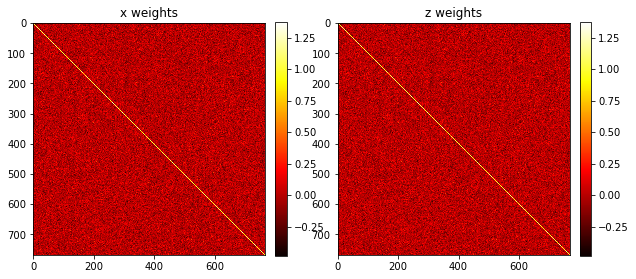

In [31]:
weight_heatmap(M, M)